### Imports and Definitions

In [1]:
from copy import copy
from gzip import open as gopen
from matplotlib import rcParams
from matplotlib.patches import Patch
from pickle import load,dump
from seaborn import pointplot,set_context,set_style
import matplotlib.pyplot as plt
EART = r'E_{ART}'
ED = r'E_{d}'

### Aesthetics

In [2]:
RC = {
    "font.size":12,
    "axes.titlesize":16,
    "axes.labelsize":14,
    "legend.fontsize":10,
    "xtick.labelsize":10,
    "ytick.labelsize":10
}

meta = {
    'color': {
        'avg_clade': '#00FF00',
        'expected': '#000000',
        'hivtrace': '#880000',
        'max': '#000088',
        'max_clade': '#0000FF',
        'single_linkage': '#FF0000',
        'sum_branch': '#008800',
        'sum_branch_clade': '#00FF00',
    },

    'label': {
        'avg_clade': 'Average (Clade)',
        'expected': 'Expected',
        'hivtrace': r'GD + Cluster Growth $(t=1.5\%)$',
        'max': r'Max $(t=4.5\%)$',
        'max_clade': r'Max (Clade) $(t=4.5\%)$',
        'single_linkage': r'Single-Linkage $(t=3\%)$',
        'sum_branch': r'Sum Branch $(t=9\%)$',
        'sum_branch_clade': r'Sum Branch (Clade) $(t=9\%)$',
    },

    'linestyle': {
        'avg_clade': '-',
        'expected': '--',
        'hivtrace': ':',
        'max': '-',
        'max_clade': '-',
        'single_linkage': '-',
        'sum_branch': '-',
        'sum_branch_clade': '-',
    }
}

set_context("paper", rc=RC)
set_style("ticks")
rcParams['font.family'] = 'serif'

### Effectiveness vs. ART and Expected Degree

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


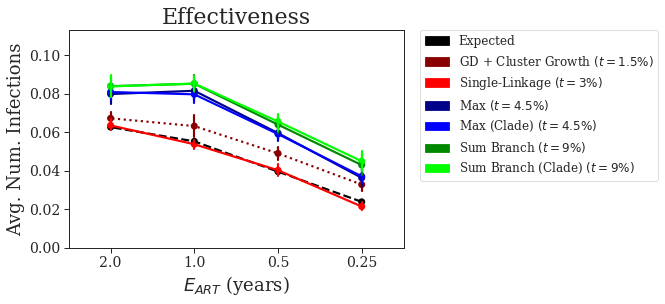

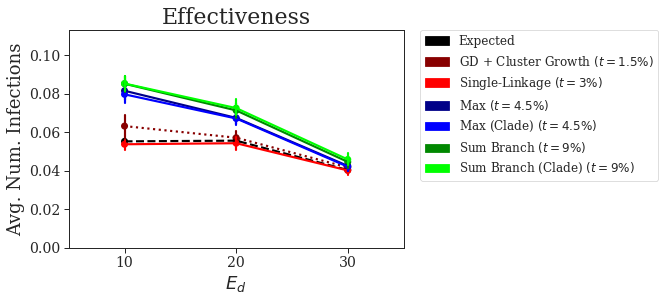

In [3]:
eff_order = ['expected','hivtrace','single_linkage','max','max_clade','sum_branch','sum_branch_clade']
eff_handles = [Patch(color=meta['color'][m], label=meta['label'][m]) for m in eff_order]
eff_data = load(gopen('DATA.EFFECTIVENESS.pkl.gz'))
eff_ymax = max(e for d in eff_data for r in eff_data[d] for m in eff_data[d][r] for e in eff_data[d][r][m])
rc = copy(RC); rc["legend.fontsize"]=12; rc["xtick.labelsize"]=14; rc["ytick.labelsize"]=14; set_context("paper", rc=rc)

# Effectiveness vs. ART
fig = plt.figure()
for m in eff_order:
    x = list(); y = list()
    for r in sorted(eff_data[10].keys()):
        y += eff_data[10][r][m]; x += [1./r]*len(eff_data[10][r][m])
    ax = pointplot(x=x, y=y, color=meta['color'][m], linestyles=meta['linestyle'][m])
ax.invert_xaxis()
plt.ylim(ymin=0, ymax=eff_ymax)
plt.title("Effectiveness", size=22)
plt.xlabel(r"$%s$ (years)"%EART, size=18)
plt.ylabel("Avg. Num. Infections", size=18)
legend = plt.legend(handles=eff_handles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True)
plt.show()
fig.savefig('effectiveness_art.pdf', format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()

# Effectiveness vs. Expected Degree
fig = plt.figure()
for m in eff_order:
    x = list(); y = list()
    for d in sorted(eff_data.keys()):
        y += eff_data[d][1][m]; x += [d]*len(eff_data[d][1][m])
    ax = pointplot(x=x, y=y, color=meta['color'][m], linestyles=meta['linestyle'][m])
plt.ylim(ymin=0, ymax=eff_ymax)
plt.title("Effectiveness", size=22)
plt.xlabel(r"$%s$"%ED, size=18)
plt.ylabel("Avg. Num. Infections", size=18)
legend = plt.legend(handles=eff_handles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True)
plt.show()
fig.savefig('effectiveness_degree.pdf', format='pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.close()
set_context("paper", rc=RC)